### Boiler plate

In [2]:
%pip install awswrangler --quiet
from re import sub 
from functools import partial

from sklearn.cluster import OPTICS, cluster_optics_dbscan
import boto3
import awswrangler as wr
import pandas as pd
session = boto3.Session()


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# you need to change this `s3_output` to a directory/S3 bucket that you have permissions to access
s3_output='s3://universityose-bucket/yvlcmb/awswrangler/'

fetch = partial(wr.athena.read_sql_query, 
                database='universityose_db', 
                boto3_session=session,
                s3_output=s3_output)

In [4]:
cols = {
    "flightid": "flightid",
    'flightstate_rates_rollrate': 'roll_rate',
    'flightstate_rates_yawrate': 'yaw_rate',
    'flightstate_rates_pitchrate': 'pitch_rate',
    "times_timestamp":"timestamp",
    "times_seconds":"seconds",
    "engines_computations_e1torque": "e1torque",
    "engines_computations_e2torque": "e2torque",
    "flightstate_altitudes_gpsaltitude":"altitude",
    "rotors_mainrotorrpmpercentage": "rotor_rpm",
    "flightstate_rates_climbordescentrate":"climb_descent"
}

def create_sql_from_flightid(flightid, cols=cols):
    sql_query = ''.join((
        'SELECT ', 
        *[f'{k} AS {v}, ' for k, v in cols.items()], 
        "FROM flight_details ", 
        f"WHERE flightid = '{flightid}'"))
    return sub(', FROM', ' FROM', sql_query)


def fetch_flight(flightid: str) -> 'DataFrame':
    """Query a flight from Athena using a flightid,
    return the result as  a Pandas Dataframe, sorted
    by seconds, with vertical acceleration calculated"""
    fix = fetch(create_sql_from_flightid(flightid))
    df = fix.sort_values('seconds').reset_index()
    assert df.seconds.min() == df.at[0, 'seconds'] and df.seconds.max() == df.iloc[-1].seconds
    df['vert_accel'] = (
        (df.climb_descent - df.climb_descent.shift(1)) / 
        (df.seconds - df.seconds.shift(1))
    )
    return df[df.columns[1:]]

### Define flights and ranges of rows that contain low-G events

In [5]:
# this dictionary contains flightids as keys and tuples of integers representing the ranges of rows where low-g occurred as values
# ...using (None) as a second item in the value if there are no other ranges is an ugly work-around that needs to be updated 

flights_and_events= {
    "31dcb8_20230216T191746_20230216T192349": (
        (10600, 11000), 
        (None)),
    "31dcb8_20230615T200220_20230615T201354": (
        (19500, 20100), 
        (None)),
    "31dcb8_20230216T151400_20230216T152827": (
        (34800, 35000), 
        (28350, 28700)),
    "31dcb8_20221020T164314_20221020T170607": (
        (7400, 7700),
        (16150, 16300),
        (23900, 24300),
        (36050, 36200), 
        (50500, 51000)),
    "31dcb8_20221006T134902_20221006T141008": (
        (6120, 6190),
        (43000, 43500), 
        (45600, 45825), 
        (46950, 47075),
        (55550, 55675),
        (51100, 51275)),
    "31dcb8_20230615T193227_20230615T200139": (
        (51100, 51400), 
        (33600, 34100), 
        (13700, 14000), 
        (26425, 26600), 
        (20350, 20600), 
        (44750, 44925),
        (61100, 61250)), 
    "31dcb8_20230615T160258_20230615T163145": (
        (43800, 44500), 
        (44800, 45200)),
    "31dcb8_20230615T145234_20230615T152543": (
        (64800, 65100), 
        (None)),
    "31dcb8_20221006T131452_20221006T134556": (
        (22500, 22900), 
        (47350, 47550), 
        (50600, 50700),
        (77300, 77700)),
    "31dcb8_20221020T211929_20221020T220157": (
        (20200, 21250),
        (24725, 24825),
        (28550, 28650),
        (30400, 31300), 
        (41500, 42000)),
    "31dcb8_20221006T145214_20221006T153158": (
        (41250, 41750), 
        (46300, 46800), 
        (36600, 36800), 
        (39180,39400)),
    "31dcb8_20230126T205028_20230126T205649": (
        (14200, 14800), 
        (None)),
    "31dcb8_20230615T133129_20230615T135220": (
        (29350, 29600), 
        (31550, 31700), 
        (34350, 34500))
}

In [6]:
frames = [fetch_flight(flightid) for flightid in flights_and_events.keys()]

### Label the rows for each flight

In [7]:
first = lambda seq: seq[0]; last = lambda seq: seq[-1]

for frame in frames: 
    frame['label'] = 0
    ranges = flights_and_events.get(frame.at[0, "flightid"])
    for r in ranges: 
        if r: 
            for i in range(first(r), last(r)+1):
                frame.at[i, 'label'] = 1

In [8]:
label_count = sum([frame.label.sum() for frame in frames])
not_label_count = sum([len(frame[frame['label']==0]) for frame in frames])
total_count = sum([len(frame) for frame in frames])
print(f'There are {label_count} labeled rows from a total of {total_count}.')
print(f'Labeled rows: {round((label_count/total_count) * 100, 2)}%')
print(f'Non-labeled rows: {round((not_label_count/total_count) * 100, 2)}%')

There are 13882 labeled rows from a total of 780457.
Labeled rows: 1.78%
Non-labeled rows: 98.22%


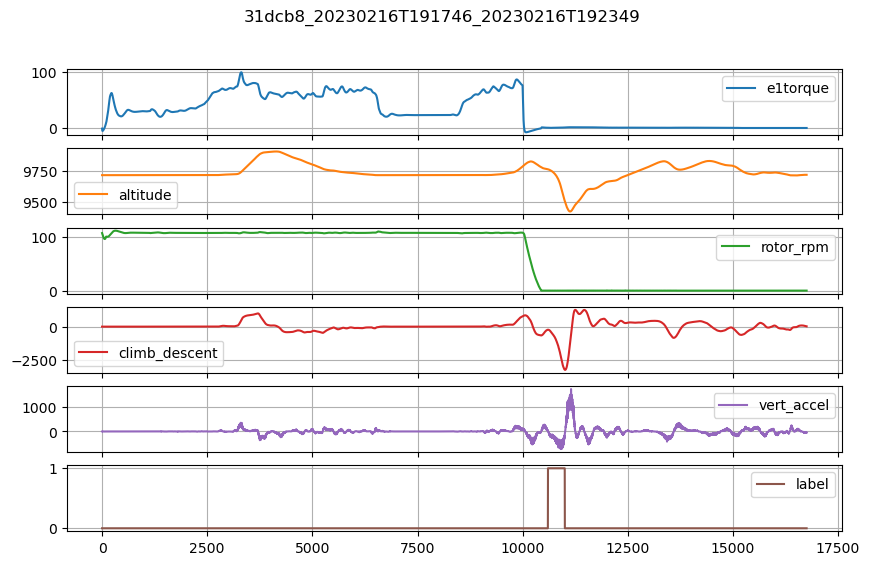

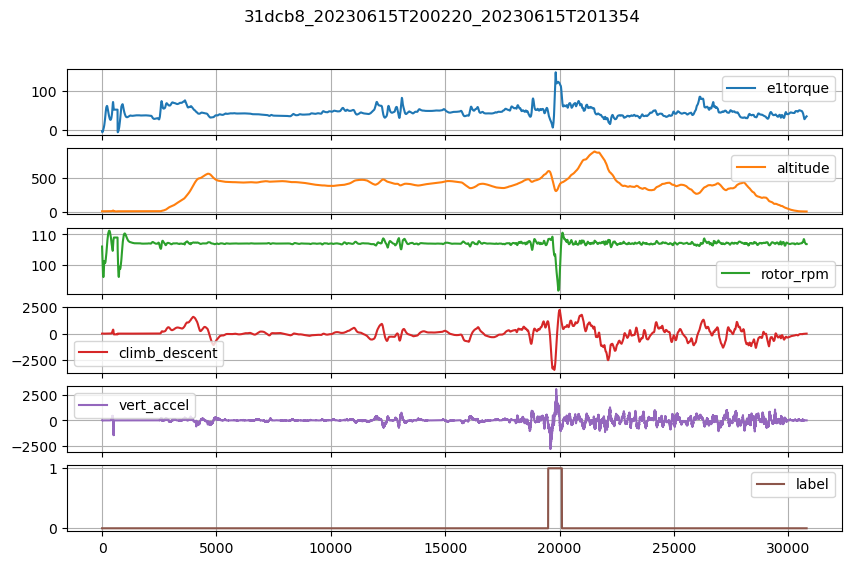

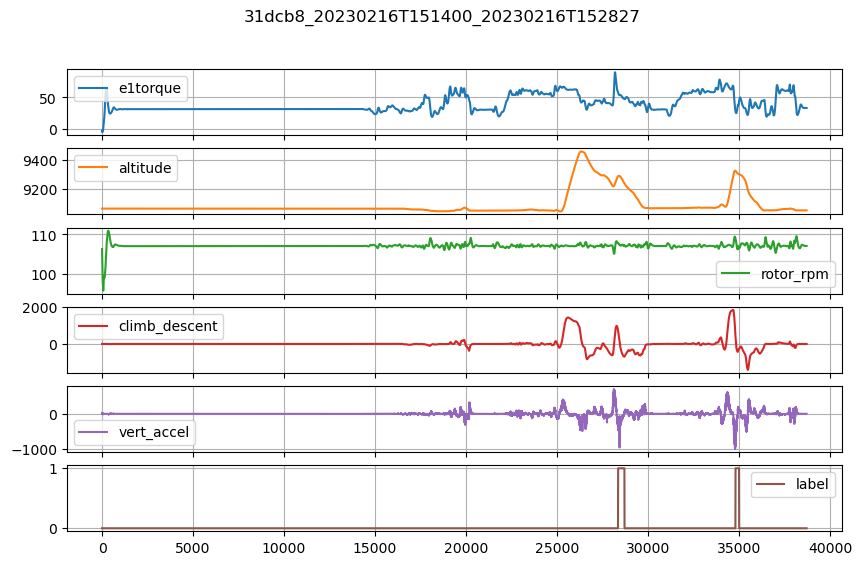

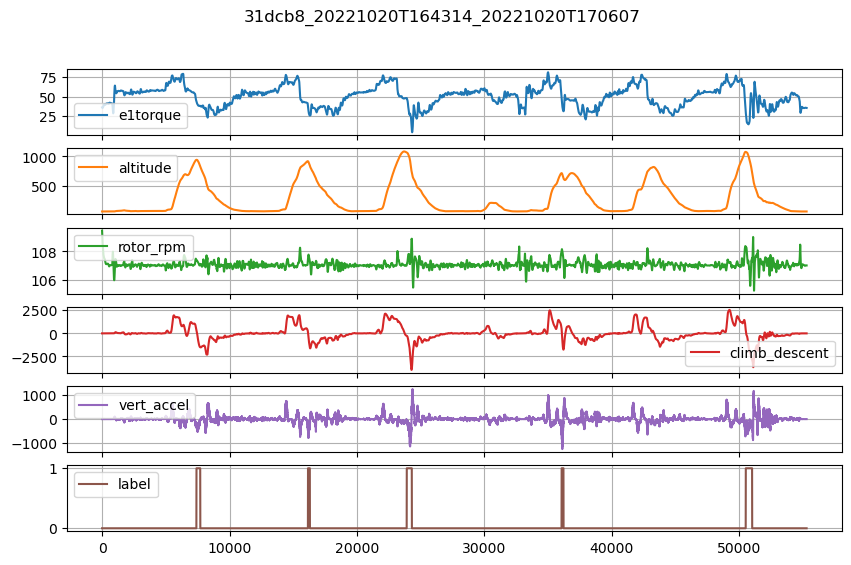

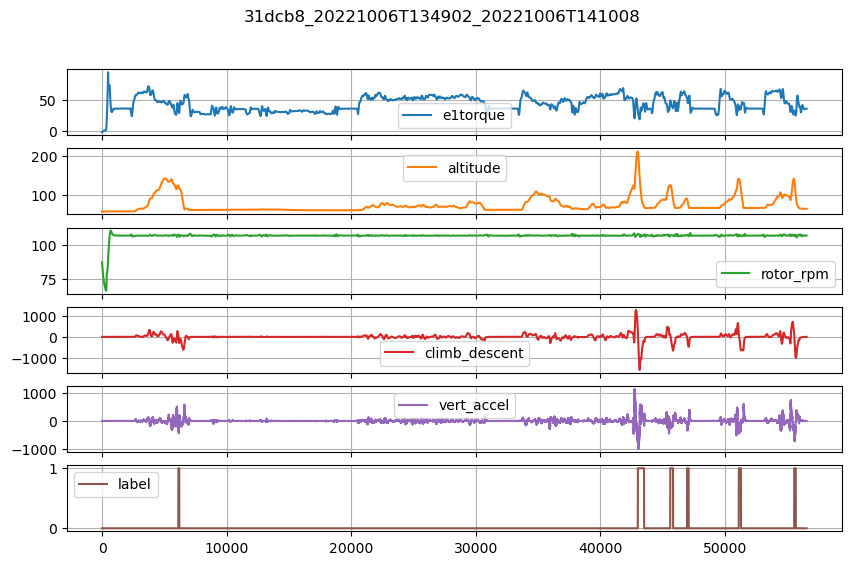

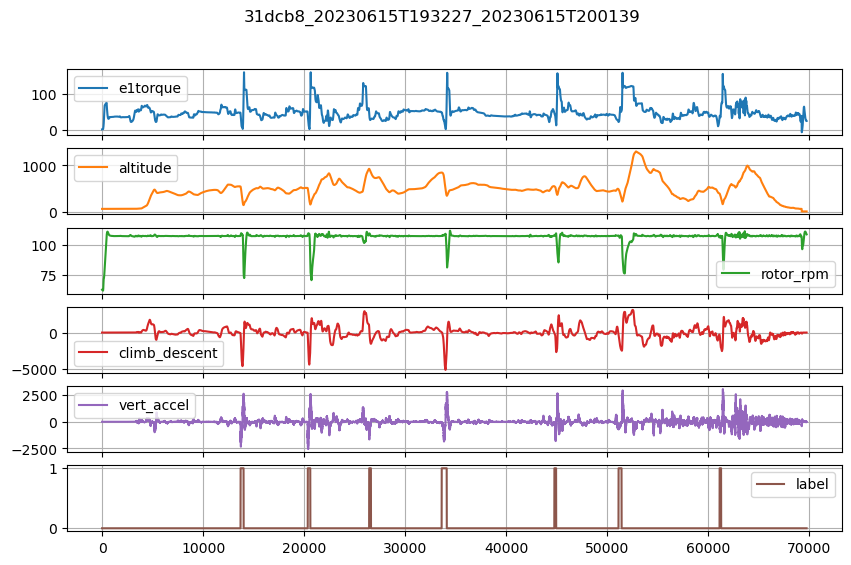

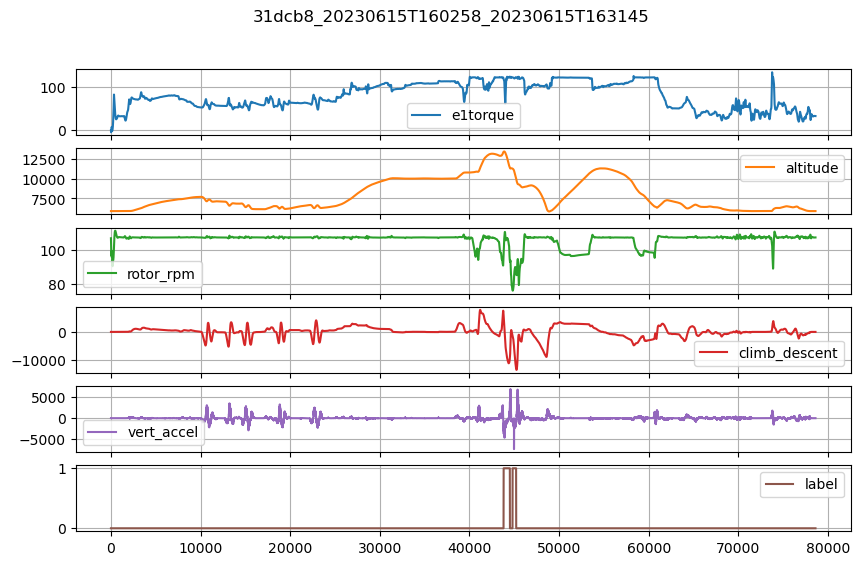

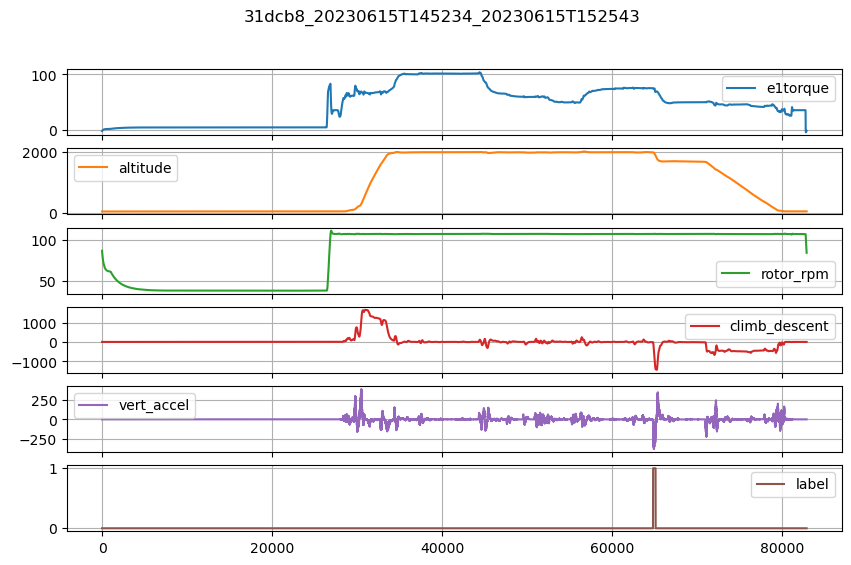

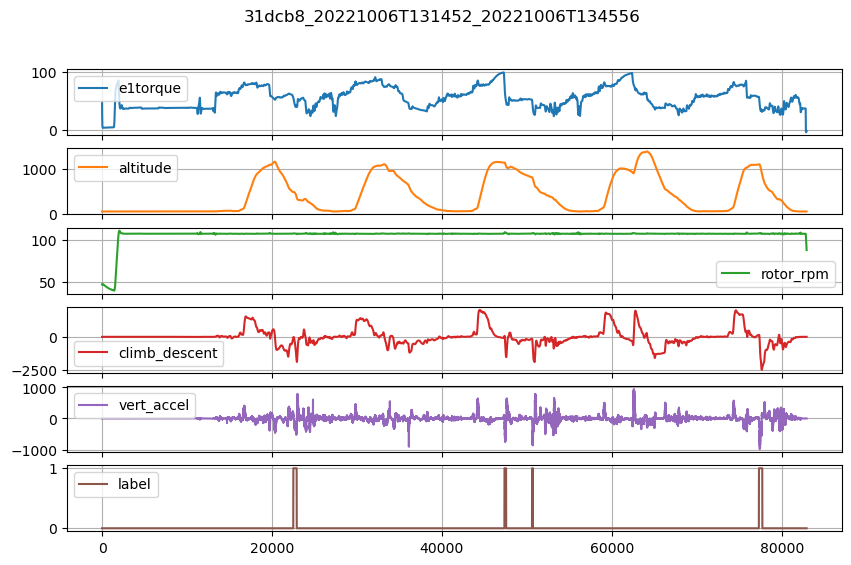

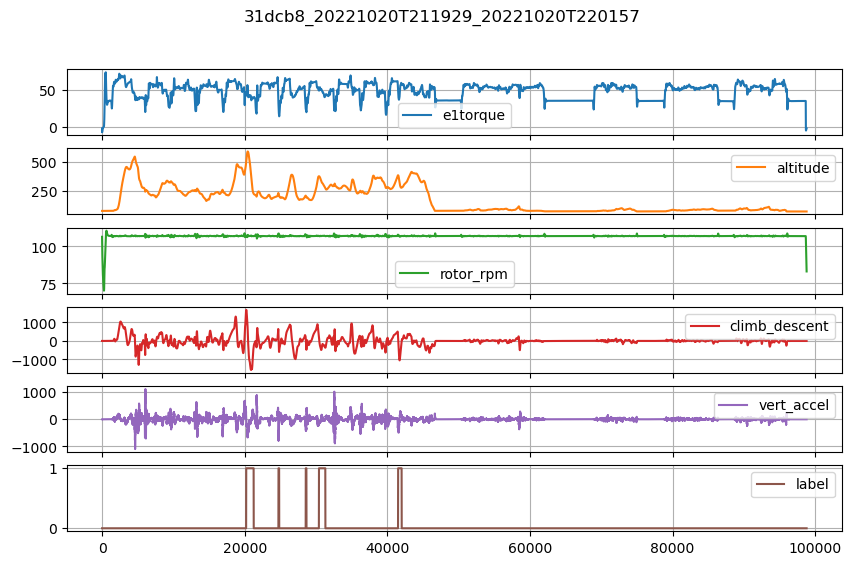

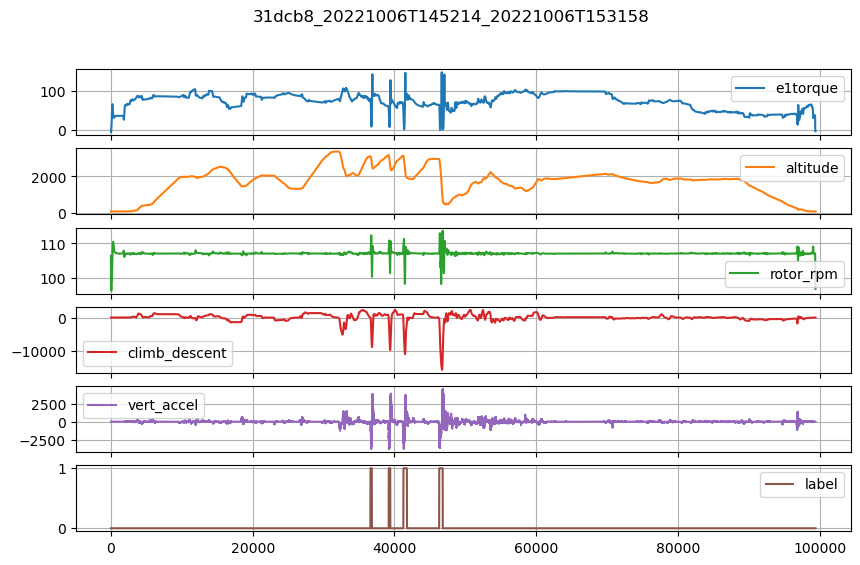

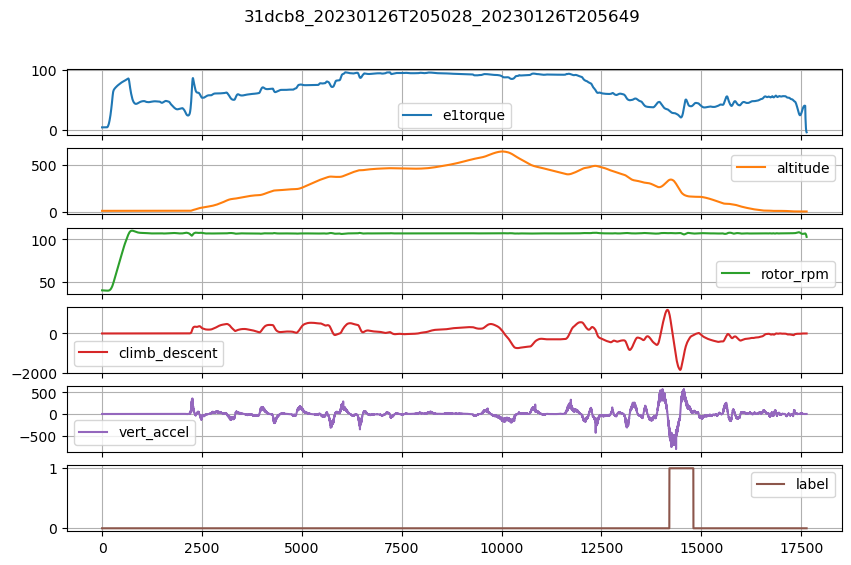

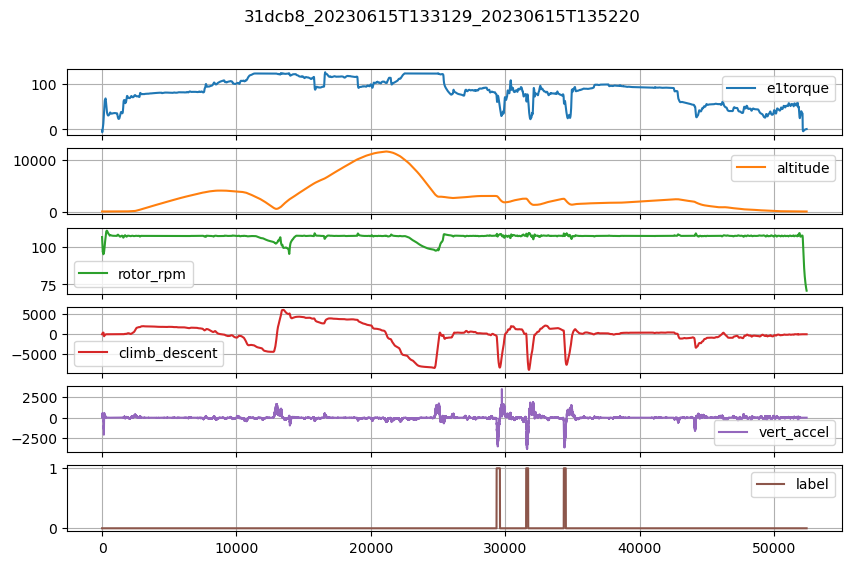

In [9]:
# this graphic shows the labeled sections that contain probably low-G events (values of 1 on the bottom subplot)
plot_these = ['e1torque', 'altitude', 'rotor_rpm', 'climb_descent', 'vert_accel', 'label']
for frame in frames: 
    frame[plot_these].plot(subplots=True, grid=True, figsize=(10,6), title=frame.at[0, 'flightid'])

In [10]:
def plot_suspect(frame, rows):
    """Zoom in to specific rows of a dataframe to plot
    
    Parameters
    ----------
    rows: a tuple/list/set indicating start & stop range of rows to plot
    
    Example
    -------
    >>> plot_suspect(frame=df, rows=(43800, 44500))
    """
    frame[rows[0]:rows[1]][plot_these].plot(
    title=frame.at[0, 'flightid'],
    subplots=True,
    grid=True,
    figsize=(10,6))

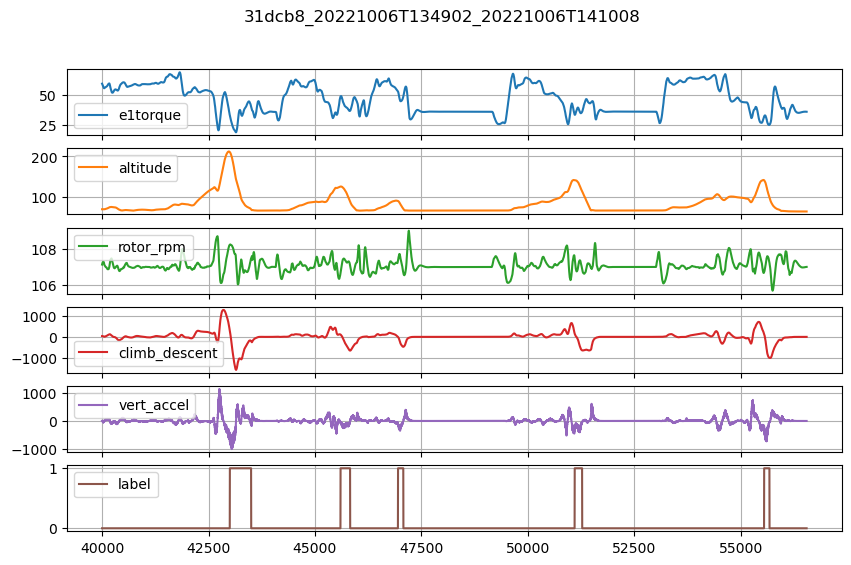

In [11]:
plot_suspect(frames[4], (40000, 65000))

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
scaler = StandardScaler()

In [13]:
# to demonstrate some models, only use a sample of three flights
# these three flights consitute about 40% of the total low-G events
# but only about 25% of the total rows 
sample = frames[3:6]
combined = pd.concat(sample) 
keep = [
    'climb_descent', 
    'vert_accel',
    'rotor_rpm', 
    'e1torque', 
    'e2torque', 
    'altitude',
    'label',
]
combined = combined[keep].dropna() 
combined.describe()

climb_descent     vert_accel      rotor_rpm       e1torque  \
count  181544.000000  181544.000000  181544.000000  181544.000000   
mean       -0.453443      -0.350478     106.676831      47.283302   
std       671.632590     195.337481       3.277618      16.081209   
min     -5130.668000   -2556.430248      62.287000      -6.534000   
25%      -140.168000     -30.235995     106.958000      35.807000   
50%        -0.019000       0.000000     107.020000      46.021500   
75%        89.593750      28.159979     107.146000      55.305000   
max      3122.099000    3062.156207     111.410000     160.906000   

            e2torque       altitude          label  
count  181544.000000  181544.000000  181544.000000  
mean       47.283302     291.166901       0.025272  
std        16.081209     267.798874       0.156951  
min        -6.534000       1.240000       0.000000  
25%        35.807000      66.540000       0.000000  
50%        46.021500     128.920000       0.000000  
75%        55.305000     482.740000       0.000000  
max       160.906000    1300.290000       1.000000

In [14]:
# drop index and create X and y
df = combined.reset_index(drop=True)
# define independent variables and dependent variable
X = df.drop('label', axis=1)
y = df['label']

# create training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=1)

In [15]:
X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)

### Support vector machine with radial basis function


#### Gamma of 1

In [45]:
clf = svm.SVC(kernel='rbf', gamma=1)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train) 
print(*zip(
    ('train accuracy: ',
     'train recall: ', 
     'train precision: ',
     'train f1: '),
    (round(metrics.accuracy_score(y_train, y_train_pred), 3),
     round(metrics.recall_score(y_train, y_train_pred), 3),
     round(metrics.precision_score(y_train, y_train_pred), 3),
     round(metrics.f1_score(y_train, y_train_pred), 3))), 
    sep='\n')
print('-'*len("('train_precision: ', 0.999)"))
y_pred = clf.predict(X_test)
print(*zip(
    ('test accuracy:',
     'test recall:', 
     'test precision:',
     'test f1:'),
    (round(metrics.accuracy_score(y_test, y_pred), 3),
     round(metrics.recall_score(y_test, y_pred), 3),
     round(metrics.precision_score(y_test, y_pred), 3),
     round(metrics.f1_score(y_test, y_pred), 3))), 
    sep='\n')

('train accuracy: ', 0.995)
('train recall: ', 0.822)
('train precision: ', 0.968)
('train f1: ', 0.889)
----------------------------
('test accuracy: ', 0.994)
('test recall: ', 0.789)
('test precision: ', 0.965)
('test f1: ', 0.868)


#### Gamma of 3

In [43]:
clf = svm.SVC(kernel='rbf', gamma=3)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train) 
print(*zip(
    ('train accuracy:',
     'train recall:', 
     'train precision:',
     'train f1:'),
    (round(metrics.accuracy_score(y_train, y_train_pred), 3),
     round(metrics.recall_score(y_train, y_train_pred), 3),
     round(metrics.precision_score(y_train, y_train_pred), 3),
     round(metrics.f1_score(y_train, y_train_pred), 3))), 
    sep='\n')
print('-'*len("('train_precision: ', 0.999)"))
y_pred = clf.predict(X_test)
print(*zip(
    ('test accuracy:',
     'test recall:', 
     'test precision:',
     'test f1:'),
    (round(metrics.accuracy_score(y_test, y_pred), 3),
     round(metrics.recall_score(y_test, y_pred), 3),
     round(metrics.precision_score(y_test, y_pred), 3),
     round(metrics.f1_score(y_test, y_pred), 3))), 
    sep='\n')

('train accuracy: ', 0.998)
('train recall: ', 0.94)
('train precision: ', 0.989)
('train f1: ', 0.964)
--------------------------
('test accuracy: ', 0.997)
('test recall: ', 0.888)
('test precision: ', 0.981)
('test f1: ', 0.932)


#### Gamma of 5

In [44]:
clf = svm.SVC(kernel='rbf', gamma=5)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train) 
print(*zip(
    ('train accuracy:',
     'train recall:', 
     'train precision:',
     'train f1:'),
    (round(metrics.accuracy_score(y_train, y_train_pred), 3),
     round(metrics.recall_score(y_train, y_train_pred), 3),
     round(metrics.precision_score(y_train, y_train_pred), 3),
     round(metrics.f1_score(y_train, y_train_pred), 3))), 
    sep='\n')
print('-'*len("('train_precision: ', 0.999)"))
y_pred = clf.predict(X_test)
print(*zip(
    ('test accuracy:',
     'test recall:', 
     'test precision:',
     'test f1:'),
    (round(metrics.accuracy_score(y_test, y_pred), 3),
     round(metrics.recall_score(y_test, y_pred), 3),
     round(metrics.precision_score(y_test, y_pred), 3),
     round(metrics.f1_score(y_test, y_pred), 3))), 
    sep='\n')

('train accuracy: ', 0.999)
('train recall: ', 0.959)
('train precision: ', 0.99)
('train f1: ', 0.974)
--------------------------
('test accuracy: ', 0.997)
('test recall: ', 0.894)
('test precision: ', 0.982)
('test f1: ', 0.936)


### Artificial neural network

In [ ]:
from sklearn.neural_network import MLPClassifier

#### Adam solver with 0.01 learning rate 

In [59]:
clf = MLPClassifier(random_state=1, max_iter=100, learning_rate_init=0.01, solver='adam').fit(X_train, y_train)

In [60]:
y_train_pred = clf.predict(X_train)
print(*zip(
    ('train accuracy:',
     'train recall:', 
     'train precision:',
     'train f1:'),
    (round(metrics.accuracy_score(y_train, y_train_pred), 3),
     round(metrics.recall_score(y_train, y_train_pred), 3),
     round(metrics.precision_score(y_train, y_train_pred), 3),
     round(metrics.f1_score(y_train, y_train_pred), 3))), 
    sep='\n')

y_pred = clf.predict(X_test)
print(*zip(
    ('test accuracy:',
     'test recall:', 
     'test precision:',
     'test f1:'),
    (round(metrics.accuracy_score(y_test, y_pred), 3),
     round(metrics.recall_score(y_test, y_pred), 3),
     round(metrics.precision_score(y_test, y_pred), 3),
     round(metrics.f1_score(y_test, y_pred), 3))), 
    sep='\n')

('train accuracy:', 0.996)
('train recall:', 0.954)
('train precision:', 0.902)
('train f1:', 0.927)
('test accuracy:', 0.996)
('test recall:', 0.943)
('test precision:', 0.902)
('test f1:', 0.922)


### Ensemble Methods

In [62]:
from sklearn import ensemble

#### Ada Boost

In [ ]:
svc=svm.SVC(kernel='rbf', gamma=1)
clf = ensemble.AdaBoostClassifier(n_estimators=100, estimator=svc,learning_rate=1,algorithm='SAMME').fit(X_train, y_train)

In [ ]:
y_train_pred = clf.predict(X_train)
print(*zip(
    ('train accuracy:',
     'train recall:', 
     'train precision:',
     'train f1:'),
    (round(metrics.accuracy_score(y_train, y_train_pred), 3),
     round(metrics.recall_score(y_train, y_train_pred), 3),
     round(metrics.precision_score(y_train, y_train_pred), 3),
     round(metrics.f1_score(y_train, y_train_pred), 3))), 
    sep='\n')

y_pred = clf.predict(X_test)
print(*zip(
    ('test accuracy:',
     'test recall:', 
     'test precision:',
     'test f1:'),
    (round(metrics.accuracy_score(y_test, y_pred), 3),
     round(metrics.recall_score(y_test, y_pred), 3),
     round(metrics.precision_score(y_test, y_pred), 3),
     round(metrics.f1_score(y_test, y_pred), 3))), 
    sep='\n')

#### Gradient Boost

In [72]:
clf = ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=1).fit(X_train, y_train)

In [73]:
y_train_pred = clf.predict(X_train)
print(*zip(
    ('train accuracy:',
     'train recall:', 
     'train precision:',
     'train f1:'),
    (round(metrics.accuracy_score(y_train, y_train_pred), 3),
     round(metrics.recall_score(y_train, y_train_pred), 3),
     round(metrics.precision_score(y_train, y_train_pred), 3),
     round(metrics.f1_score(y_train, y_train_pred), 3))), 
    sep='\n')

y_pred = clf.predict(X_test)
print(*zip(
    ('test accuracy:',
     'test recall:', 
     'test precision:',
     'test f1:'),
    (round(metrics.accuracy_score(y_test, y_pred), 3),
     round(metrics.recall_score(y_test, y_pred), 3),
     round(metrics.precision_score(y_test, y_pred), 3),
     round(metrics.f1_score(y_test, y_pred), 3))), 
    sep='\n')

('train accuracy:', 0.976)
('train recall:', 0.271)
('train precision:', 0.545)
('train f1:', 0.362)
('test accuracy:', 0.975)
('test recall:', 0.263)
('test precision:', 0.5)
('test f1:', 0.344)


#### RandomForestClassifier

In [ ]:
clf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=None, random_state=1)

In [ ]:
y_train_pred = clf.predict(X_train)
print(*zip(
    ('train accuracy:',
     'train recall:', 
     'train precision:',
     'train f1:'),
    (round(metrics.accuracy_score(y_train, y_train_pred), 3),
     round(metrics.recall_score(y_train, y_train_pred), 3),
     round(metrics.precision_score(y_train, y_train_pred), 3),
     round(metrics.f1_score(y_train, y_train_pred), 3))), 
    sep='\n')

y_pred = clf.predict(X_test)
print(*zip(
    ('test accuracy:',
     'test recall:', 
     'test precision:',
     'test f1:'),
    (round(metrics.accuracy_score(y_test, y_pred), 3),
     round(metrics.recall_score(y_test, y_pred), 3),
     round(metrics.precision_score(y_test, y_pred), 3),
     round(metrics.f1_score(y_test, y_pred), 3))), 
    sep='\n')